In [3]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import itertools
import functools
from matplotlib.animation import FuncAnimation, PillowWriter, MovieWriter 
from IPython import display
from copy import copy, deepcopy
from time import time

In [4]:
def generate_set_a(number_of_points = 100, left = -100, right = 100):
    return np.array([[random.uniform(left, right), random.uniform(left, right)] for _ in range(number_of_points)])


def generate_set_b(number_of_points = 100, O = (0, 0), R = 10):
    points = [[None, None] for _ in range(100)]
    
    for i in range(number_of_points):
        t = random.uniform(0, 2*np.pi)
        points[i][0] = R * np.cos(t) + O[0]
        points[i][1] = R * np.sin(t) + O[1]
    
    return np.array(points)


def generate_set_c(number_of_points = 100, lower_left_corner = (-10, -10), upper_right_corner = (10, 10)):
    l = lower_left_corner[0]
    r = upper_right_corner[0]
    u = upper_right_corner[1]
    d = lower_left_corner[1]

    points = [[] for _ in range(number_of_points)]
    
    for i in range(number_of_points):
        side = random.randint(1, 4)
        if side == 1:
            x, y = random.uniform(l, r), d
        elif side == 2:
            x, y = l, random.uniform(d, u)
        elif side == 3:
            x, y = random.uniform(l, r), u
        elif side == 4:
            x, y = r, random.uniform(d, u)
        points[i] = [x, y]
    
    return np.array(points)


def generate_set_d(lower_left_corner = (0, 0), a = 10, on_axes = 25, on_diagonal = 20):
    points = [[None, None] for _ in range(94)]
    x0 = 0
    y0 = 0
    a = 10
    
    for i, element in enumerate(itertools.product([x0, x0 + a], [y0, y0 + a])):
        points[i] = element
    
    for i in range(on_axes):
        points[4 + i] = [random.uniform(x0, x0 + a), y0]
        points[4 + on_axes + i] = [x0, random.uniform(y0, y0 + a)]
        
    p = 4 + on_axes * 2
    
    for i in range(on_diagonal):
        b = y0 - x0
        x = random.uniform(x0, x0 + a)
        y = x + b
        points[p + i] = [x, y]
        
        b = y0 + x0 + a
        x = random.uniform(x0, x0 + a)
        y = -x + b
        points[p + on_diagonal + i] = [x, y]
            
    return np.array(points)


def generate_all_sets():
    return [generate_set_a(), generate_set_b(),  generate_set_c(),  generate_set_d()]

def plot(points):
    plt.scatter(points[:,0], points[:, 1], s=10)

In [5]:
set_of_points = generate_all_sets()

### Zestaw 1.

<IPython.core.display.Javascript object>


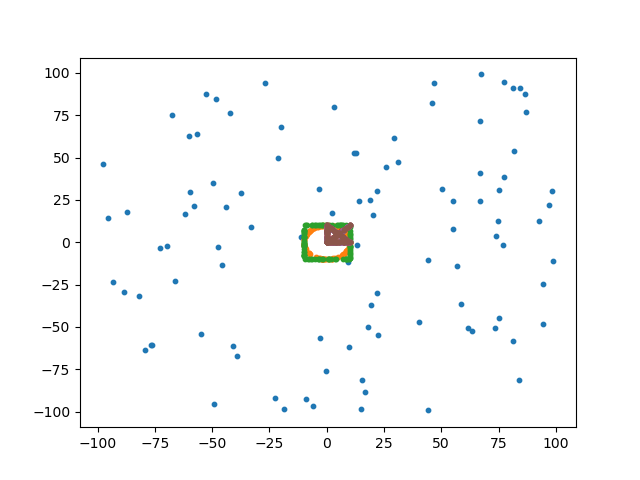

In [6]:
plot(set_of_points[0])

### Zestaw 2.

In [7]:
plot(set_of_points[1])

### Zestaw 3.

In [8]:
plot(set_of_points[2])

### Zestaw.4

In [9]:
plot(set_of_points[3])

In [263]:
def det3x3(a, b, c):
    return (a[0]*b[1]) + (a[1]*c[0]) + (b[0]*c[1])- (c[0]*b[1]) - (b[0]*a[1]) - (a[0]*c[1])


def orientation(a, b, c, tolerance = 1e-12):
    det = det3x3(a, b, c)
    if abs(det) < tolerance:
        return 0
    elif det < 0:
        return 1
    else:
        return -1
    
    
def dist(a, b):
        return ((a[0]-b[0])**2 + (a[1]-b[1])**2)**.5         

    
def sort_by_polar_angle(points, p0):  
    def compare(p1, p2):
        d = orientation(p0, p1, p2)
        if d != 0:
            return d
        else:
            if dist(p0, p1) > dist(p0, p2):
                return 1
            else:
                return -1

    presorted_points = sorted(points, key=functools.cmp_to_key(compare))
    
    to_remove = set()
    for i in range(1, len(presorted_points)):
        if orientation(p0, presorted_points[i-1],presorted_points[i]) == 0:
            to_remove.add(i - 1)
    
    sorted_points = [presorted_points[i] for i in range(len(presorted_points)) if i not in to_remove]
    

    return sorted_points

def graham_scan(points):
    start = time()
    
    idx, p0 = min(enumerate(points), key=lambda p:(p[1][1], p[1][0]))
#     print(p0, points[0], points[idx])
    p0 = copy(p0)
    tmp = copy(points[0])
    points[0] = copy(points[idx])
    points[idx] = tmp
#     print(p0, points[0], points[idx])



    sorted_points = sort_by_polar_angle(points[1:], p0)
    
    
    
    stack = []
    stack.append(copy(p0))
    stack.append(copy(sorted_points[0]))
    stack.append(copy(sorted_points[1]))
    
    intermediate_steps = [np.array(copy(stack))]
    
    m = len(sorted_points)
        
    for i in range(2, m):
        while len(stack) >= 2 and orientation(stack[-2], stack[-1], sorted_points[i]) != -1:
            stack.pop()
            intermediate_steps.append(np.array(copy(stack)))
        stack.append(copy(sorted_points[i]))
        intermediate_steps.append(np.array(copy(stack)))
    
    end = time()

    return np.array(stack), intermediate_steps, end - start


# def min_by_angle(points, p0):
#     

#     return min(points, key=functools.cmp_to_key(compare))
    

def compare(p0, p1, p2):
    d = orientation(p0, p1, p2)
    if d != 0:
        return d
    else:
        if dist(p0, p1) > dist(p0, p2):
            return -1
        else:
            return 1

def jarvis_march(points):
    start = time()
    
#     p0 = copy(min(points, key=lambda p:(p[1], p[0])))
    idx_prev, p0 = min(enumerate(points), key=lambda p:(p[1][1], p[1][0]))

    
    p1 = copy(min_by_angle(points, p0))
    
    stack = [p0]
    intermediate_steps = [copy(np.array(stack))]
    m = len(points)

    
    while True:
        p1, idx_p1 = points[0], 0
        for i in range(m):
            if i == idx_prev:
                continue
            cmp = compare(stack[-1], p1, points[i])
            if cmp == 1:
                intermediate_steps.append(copy(np.array(stack+[p1])))
                p1, idx_p1 = points[i], i
        idx_prev = idx_p1
        
        if p1[0] == p0[0] and p1[1] == p0[1]:
            break
            
        stack.append(p1)
        intermediate_steps.append(copy(np.array(stack)))
    
    end = time()
    
    return np.array(stack), intermediate_steps, end - start

def plot_hull(hull):
    plt.plot(hull[:,0], hull[:,1], c='r', marker='o')
    plt.plot([hull[0][0], hull[-1][0]], [hull[0][1], hull[-1][1]], c='r', marker='o')

In [176]:
def visualize(points, steps):
    
    fig, ax = plt.subplots()
    fig.set_tight_layout(True)
    
    ax.scatter(points[:,0], points[:,1])

    def update(i):
        ax.clear()
        ax.scatter(points[:,0], points[:,1])
        label = 'step {0}'.format(i + 1)
        ax.plot(steps[i][:, 0], steps[i][:, 1], 'ro-')
        ax.plot(steps[i][-1, 0], steps[i][-1, 1], 'go-')

        ax.set_xlabel(label)

    return FuncAnimation(fig, update, repeat=True, frames=np.arange(0, len(steps)), interval=1000)

def hull_to_file(hull, name):
    with open(name+'.txt', 'w') as file:
        file.write('\n'.join(str(x)+','+str(y) for x, y in hull))

### Algorytm Grahama

In [508]:
record = [graham_scan(p) for p in set_of_points]

#### Zestaw 1.

In [46]:
i = 0
hull, steps, t = record[i]
plot_hull(hull)
visualize(set_of_points[i], steps)

NameError: name 'record' is not defined

#### Zestaw 2.

<IPython.core.display.Javascript object>


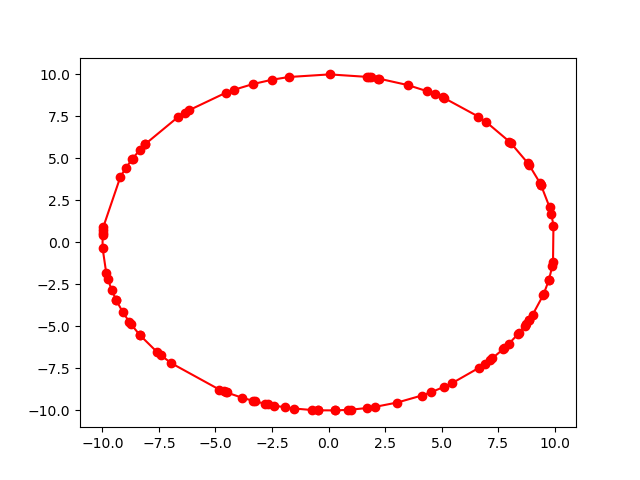

<IPython.core.display.Javascript object>


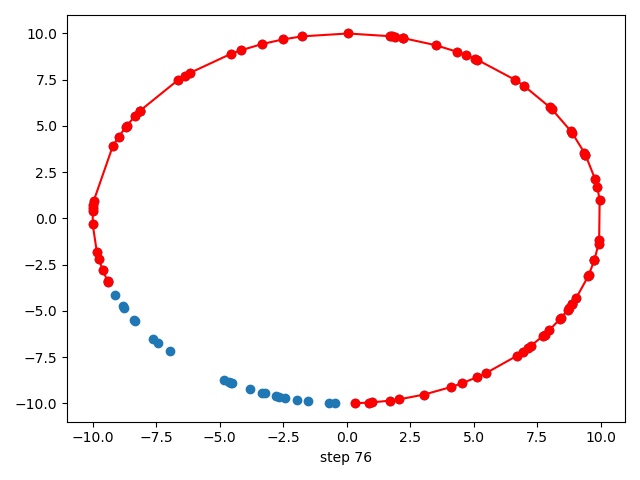

In [516]:
i = 1
hull, steps, t = record[i]
plot_hull(hull)
visualize(set_of_points[i], steps)

#### Zestaw 3.

<IPython.core.display.Javascript object>


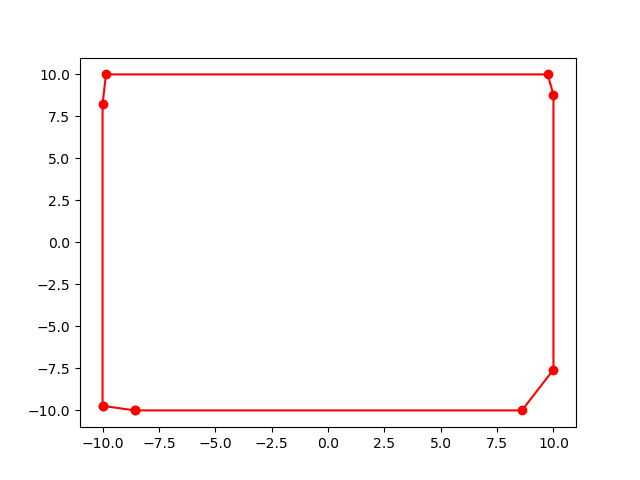

<IPython.core.display.Javascript object>


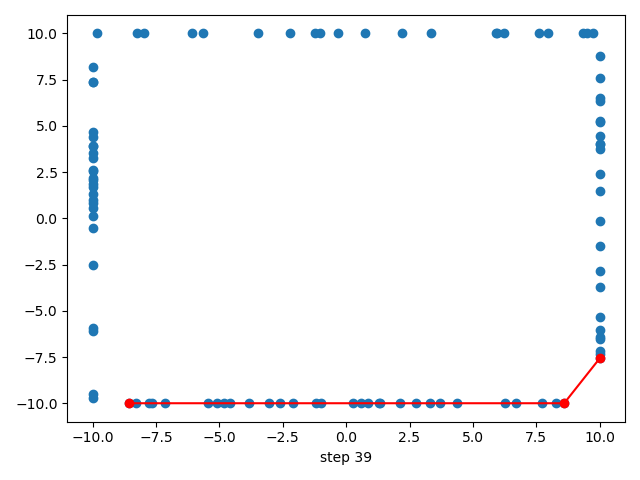

In [519]:
i = 2
hull, steps, t = record[i]
plot_hull(hull)
visualize(set_of_points[i], steps)

#### Zestaw 4.

<IPython.core.display.Javascript object>


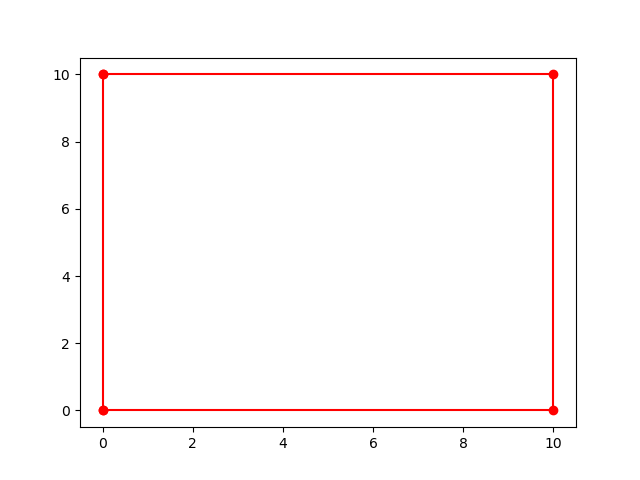

<IPython.core.display.Javascript object>


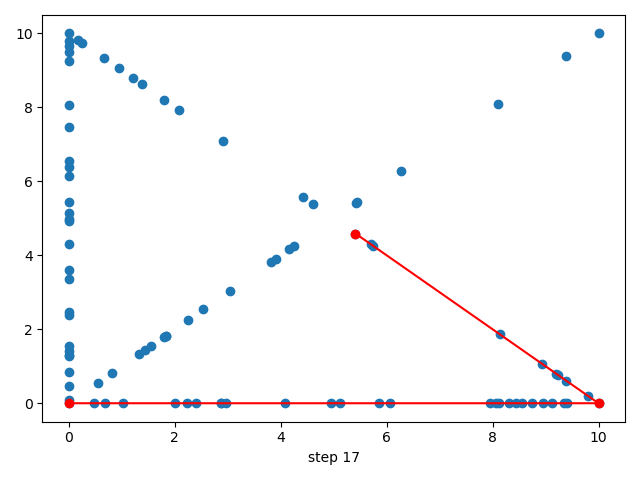

In [522]:
i = 3
hull, steps, t = record[i]
plot_hull(hull)
visualize(set_of_points[i], steps)

### Algorytm Jarvisa

In [290]:
record = [graham_scan(p) for p in set_of_points]

#### Zestaw 1.

<IPython.core.display.Javascript object>


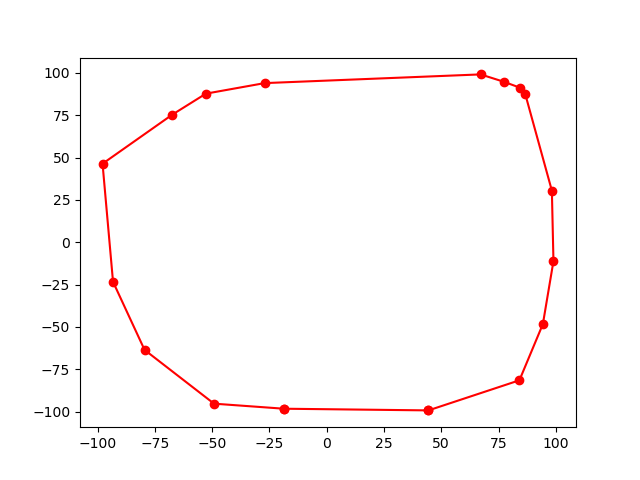

<IPython.core.display.Javascript object>


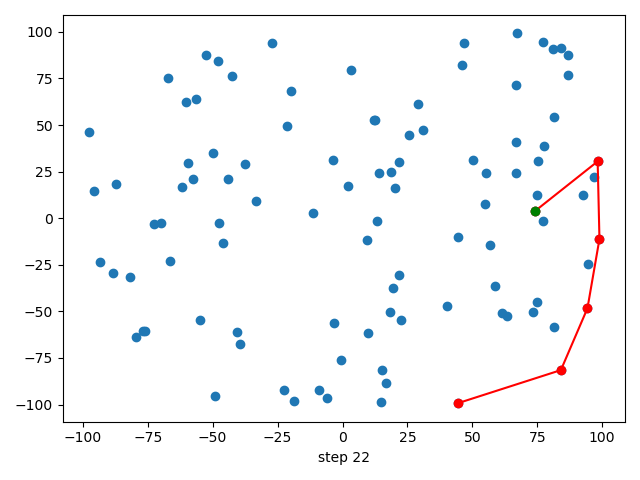

In [293]:
%matplotlib notebook
i = 0
hull, steps, t = record[i]
plot_hull(hull)
visualize(set_of_points[i], steps)

#### Zestaw 2,

<IPython.core.display.Javascript object>


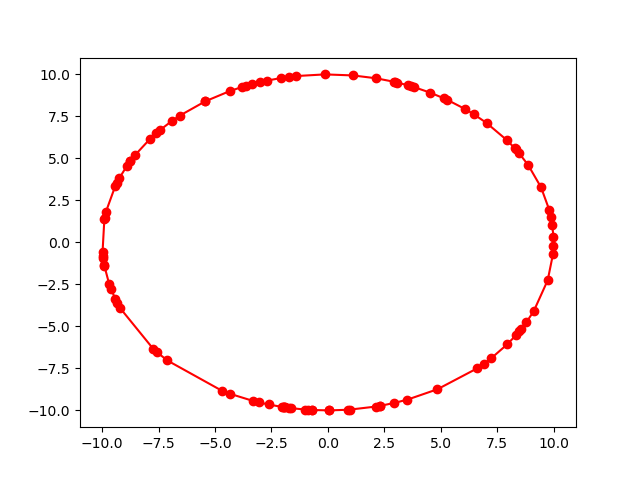

<IPython.core.display.Javascript object>


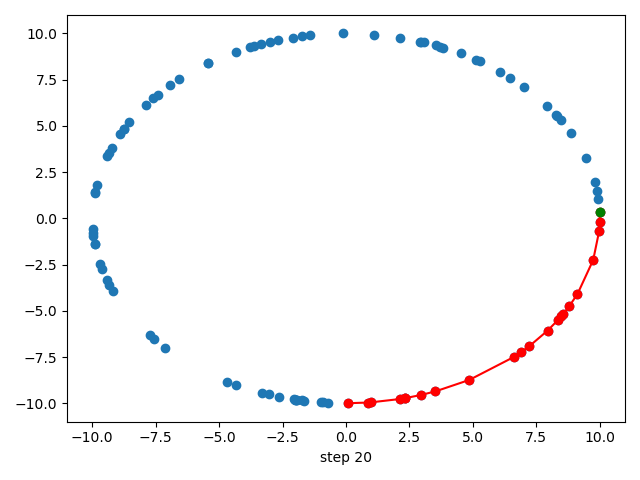

In [294]:
%matplotlib notebook
i = 1
hull, steps, t = record[i]
plot_hull(hull)
visualize(set_of_points[i], steps)

#### Zestaw 3.

<IPython.core.display.Javascript object>


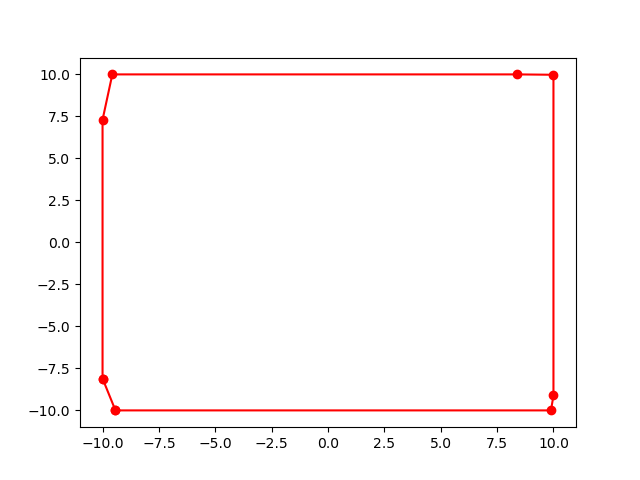

<IPython.core.display.Javascript object>


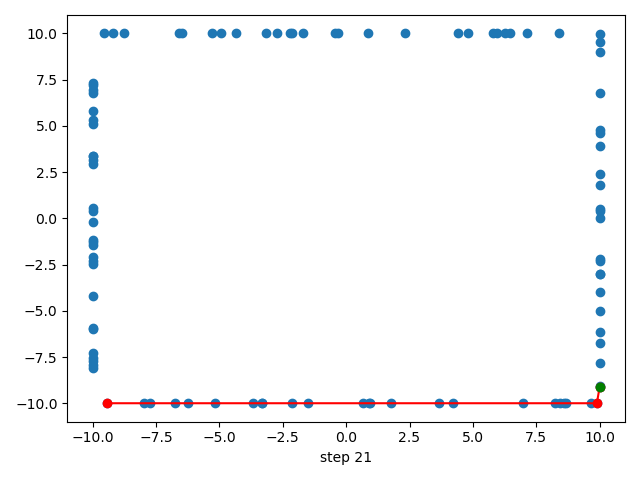

In [296]:
%matplotlib notebook
i = 2
hull, steps, t = record[i]
plot_hull(hull)
visualize(set_of_points[i], steps)

#### Zestaw 4.

<IPython.core.display.Javascript object>


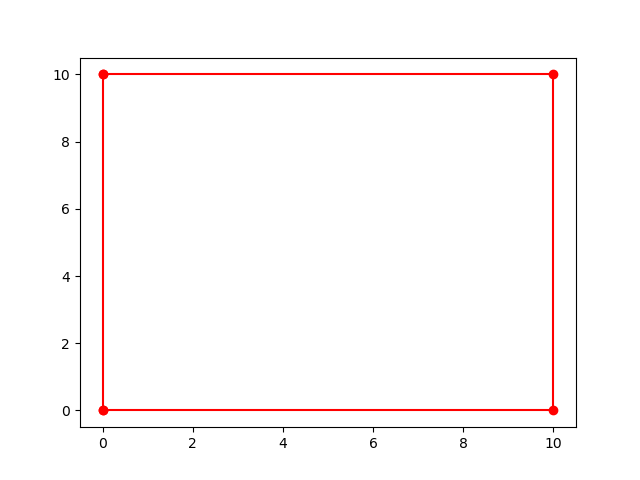

<IPython.core.display.Javascript object>


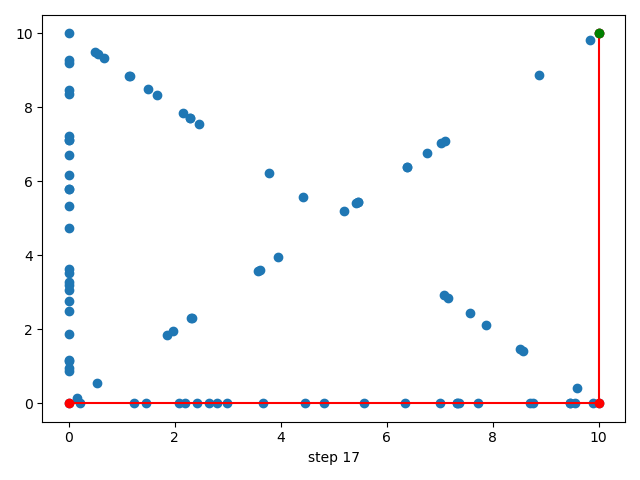

In [297]:
%matplotlib notebook
i = 3
hull, steps, t = record[i]
plot_hull(hull)
visualize(set_of_points[i], steps)